In [50]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import hashlib
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from imageio import imread
from skimage.transform import resize
from keras.models import load_model

%matplotlib inline

In [2]:
cascade_path = 'C:\\Users\\Porshe\\keras-facenet-master\\notebook\\model\\cv2\\haarcascade_frontalface_alt2.xml'

In [19]:
image_dir_basepath = 'C:\\Users\\Porshe\\keras-facenet-master\\notebook\\data\\images\\'
names = [ 'BillGates', 'charles', 'ernie', 'kenny','LarryPage', 'MarkZuckerberg','shaq','son','xi','xia']
image_size = 160

In [4]:
model_path = 'C:\\Users\\Porshe\\keras-facenet-master\\notebook\\model\\keras\\model\\facenet_keras.h5'
model = load_model(model_path)

C:\ProgramData\Anaconda3\lib\site-packages\keras-2.1.5-py3.6.egg\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [5]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [54]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier(cascade_path)
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)
        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)
            
    return np.array(aligned_images)

In [7]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [114]:
def train(dir_basepath, names, max_num_img=10):
    labels = []
    embs = []
    hash_ = []
    for name in names:
        dirpath = os.path.abspath(dir_basepath + name)
        filepaths = [os.path.join(dirpath, f) for f in os.listdir(dirpath)][:max_num_img]
        embs_ = calc_embs(filepaths)    
        labels.extend([name] * len(embs_))
        embs.append(embs_)
        
    embs = np.concatenate(embs)
    print("labels:", labels)
    le = LabelEncoder().fit(labels)
    y = le.transform(labels)
    print("y:", y)
    tmp = []
    type(y)
    
    for i in y:
        if not tmp:
            tmp.append(i)
            print("not tmp")
        if i != tmp[-1]:
            tmp.append(i)
            print("tmp:", tmp)
        else:
            continue

    for j in tmp:
        hash_.append(hashlib.sha256(("pandas" + str(j)).encode('utf-8')).hexdigest())
        print("hash:", hash_)
        
    clf = SVC(kernel='linear', probability=True).fit(embs, y)

    return le, clf, hash_

In [90]:
def infer(le, clf, filepaths):
    embs = calc_embs(filepaths)
    pred = le.inverse_transform(clf.predict(embs))
    return pred

In [115]:
le, clf, hash_ = train(image_dir_basepath, names)

labels: ['BillGates', 'BillGates', 'BillGates', 'charles', 'charles', 'charles', 'charles', 'ernie', 'ernie', 'ernie', 'ernie', 'kenny', 'kenny', 'kenny', 'LarryPage', 'LarryPage', 'LarryPage', 'MarkZuckerberg', 'MarkZuckerberg', 'MarkZuckerberg', 'shaq', 'shaq', 'shaq', 'shaq', 'shaq', 'son', 'son', 'son', 'xi', 'xi', 'xi', 'xia', 'xia', 'xia']
y: [0 0 0 3 3 3 3 4 4 4 4 5 5 5 1 1 1 2 2 2 6 6 6 6 6 7 7 7 8 8 8 9 9 9]
not tmp
tmp: [0, 3]
tmp: [0, 3, 4]
tmp: [0, 3, 4, 5]
tmp: [0, 3, 4, 5, 1]
tmp: [0, 3, 4, 5, 1, 2]
tmp: [0, 3, 4, 5, 1, 2, 6]
tmp: [0, 3, 4, 5, 1, 2, 6, 7]
tmp: [0, 3, 4, 5, 1, 2, 6, 7, 8]
tmp: [0, 3, 4, 5, 1, 2, 6, 7, 8, 9]
hash: ['30538fab2711e12aee419814f2846b996a617e44812f94f1ab4a4bfe82f69a9b']
hash: ['30538fab2711e12aee419814f2846b996a617e44812f94f1ab4a4bfe82f69a9b', '113ed6ab80071554d816828bad2db7af2e6b2af30ec183225d335f205e075119']
hash: ['30538fab2711e12aee419814f2846b996a617e44812f94f1ab4a4bfe82f69a9b', '113ed6ab80071554d816828bad2db7af2e6b2af30ec183225d335f205e075

In [37]:
test_dirpath = os.path.join(image_dir_basepath, 'Test')
test_filepaths = [os.path.join(test_dirpath, f) for f in os.listdir(test_dirpath)]

In [38]:
pred = infer(le, clf, test_filepaths)

C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\1.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\10.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\4.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\5.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\test0.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\test1.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\test2.jpg
C:\Users\Porshe\keras-facenet-master\notebook\data\images\Test\test3.jpg


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


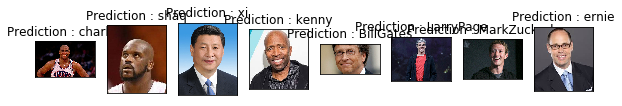

In [42]:
fig, axes = plt.subplots(1, 8, figsize=(10, 5))

for i in range(8):
    axes[i].set_title('Prediction : '+str(pred[i]))
    axes[i].imshow(imread(test_filepaths[i]))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [82]:
y = [1 1]

SyntaxError: invalid syntax (<ipython-input-82-c73461155864>, line 1)